## Import libraries

In [27]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt


## Add filters for depth image
https://github.com/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb


In [28]:
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 4)

spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
spatial.set_option(rs.option.holes_fill, 3)

temporal = rs.temporal_filter()

hole_filling = rs.hole_filling_filter()

depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)


rs.sensor members:

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'as_depth_sensor', 'as_roi_sensor', 'close', 'get_info', 'get_option', 'get_option_description', 'get_option_range', 'get_option_value_description', 'get_stream_profiles', 'is_depth_sensor', 'is_option_read_only', 'is_roi_sensor', 'open', 'profiles', 'set_notifications_callback', 'set_option', 'start', 'stop', 'supports']

rs.option members:

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__lt__', '__members__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'accuracy', 'asic_temperature', 'auto_exposure_converge_step', 'auto_exposure_mode', 'auto_exposure_priority', 'backlight_compensation', 'brightness', 'color_scheme', 'confidence_threshold', 'contrast', 'depth_units', 'emitter_enabled', 'enable_auto_exposure', 'enable_auto_white_balance', 'enable_motion_correction', 'error_polling_enabled', 'exposure', 'filter_magnitude', 'filter_option', 'filter_smooth_alpha', 'filter_smooth_delta', 'frames_queue_size', 'gain', 'gamma', 'histogram_equalization_enabled', 'holes_fill', 'hue', 'inter_cam_sync_mode', 'laser_power', 'max_distance', 'min_distance', 'motion_module_temperature', 'motion_range', 'output_trigger_enabled', 'power_line_frequency', 'projector_temperature', 'saturation', 'sharpness', 'stereo_baseline', 'stream_filter', 'stream_format_filter', 'stream_index_filter', 'texture_source', 'total_frame_drops', 'visual_preset', 'white_balance']


In [29]:
print(dir(rs.sensor))
print()
print(dir(rs.option))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'as_depth_sensor', 'as_roi_sensor', 'close', 'get_info', 'get_option', 'get_option_description', 'get_option_range', 'get_option_value_description', 'get_stream_profiles', 'is_depth_sensor', 'is_option_read_only', 'is_roi_sensor', 'open', 'profiles', 'set_notifications_callback', 'set_option', 'start', 'stop', 'supports']

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__lt__', '__members__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__

In [38]:
# Configure depth and color streams
width = 1280
height = 720
frame_rate = 6

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, frame_rate)
config.enable_stream(rs.stream.color, width, height, rs.format.bgr8, frame_rate)

# Start streaming
profile = pipeline.start(config)

# default depth_uits = 0.0010000000474974513
depth_sensor = profile.get_device().first_depth_sensor()

#0.001 (1mm) range 65m
#0.0001 (0.1mm) range 6.5m (min allowed)
#0.00001 (0.01mm) range 0.65m (error in set option)

depth_sensor.set_option(rs.option.depth_units,0.0001)

depth_sensor.get_option(rs.option.depth_units)
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
print(depth_scale)

9.999999747378752e-05


In [39]:



frame = None
depth_frame = None
color_frame = None
depth_frame_1 = None
frame_count = 0
align = rs.align(rs.stream.color)
colorizer = rs.colorizer()

# ignore the first few frames, to allow the camera auto-exposure to stabilise
while (frame_count < 30):
    frame = pipeline.wait_for_frames()
    frame_count += 1


Frame object members:

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'as_depth_frame', 'as_frame', 'as_frameset', 'as_points', 'as_video_frame', 'data', 'first', 'first_or_default', 'foreach', 'frame_number', 'frame_timestamp_domain', 'get_color_frame', 'get_data', 'get_depth_frame', 'get_frame_metadata', 'get_frame_number', 'get_frame_timestamp_domain', 'get_infrared_frame', 'get_profile', 'get_timestamp', 'is_depth_frame', 'is_frame', 'is_frameset', 'is_points', 'is_video_frame', 'keep', 'profile', 'size', 'supports_frame_metadata', 'swap', 'timestamp']


In [40]:
print(dir(frame))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'as_depth_frame', 'as_frame', 'as_frameset', 'as_points', 'as_video_frame', 'data', 'first', 'first_or_default', 'foreach', 'frame_number', 'frame_timestamp_domain', 'get_color_frame', 'get_data', 'get_depth_frame', 'get_frame_metadata', 'get_frame_number', 'get_frame_timestamp_domain', 'get_infrared_frame', 'get_profile', 'get_timestamp', 'is_depth_frame', 'is_frame', 'is_frameset', 'is_points', 'is_video_frame', 'keep', 'profile', 'size', 'supports_frame_metadata', 'swap', 'timestamp']


In [41]:
import time

# frame.timestamp = 1540527901222.4421
# time.time()     = 1540527908.8422644
# frame.timestamp is in ms
print(frame.timestamp)
print(time.time())

1540565700875.8032
1540565702.3659399


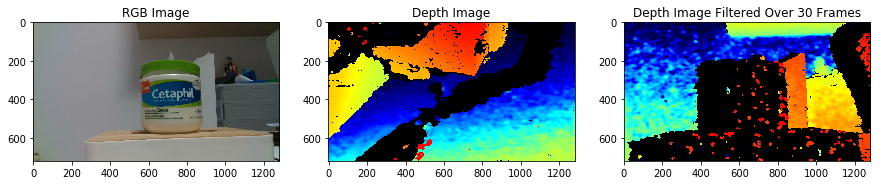

In [42]:
imgfolder = "D:/d435/test/"
frame_count = 0
frame_time = 0.0

while (frame_count < 1):
    frame = pipeline.wait_for_frames()
    frame = align.process(frame)
    frame_time = frame.timestamp
    
    depth_filename = imgfolder + "d_" + str(frame_time) + ".npy"
    color_filename = imgfolder + "c_" + str(frame_time) + ".npy"
    
    depth_frame = frame.get_depth_frame()
    color_frame = frame.get_color_frame()

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    
    np.save(depth_filename, depth_image)
    np.save(color_filename, color_image)
    # depth_frame = np.load(depth_filename)

    frame_count += 1
    


colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())

# Apply colormap on depth image (image must be converted to 8-bit per pixel first)
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

# Stack both images horizontally
#images = np.hstack((color_image, colorized_depth))

# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(cv2.cvtColor(colorized_depth_1, cv2.COLOR_BGR2RGB))

table3 = fig.add_subplot(1,3,3)
table3.set_title("Depth Image Filtered Over 30 Frames")
table3.imshow(cv2.cvtColor(colorized_depth, cv2.COLOR_BGR2RGB))



In [43]:
print(depth_image_1.shape)
print(depth_image_1[450,180])
print(depth_image_1[450,180]*depth_scale)

print(color_image.shape)
print(color_image[450,180])


(720, 1280)
24451
2.44509993823
(720, 1280, 3)
[148 142 140]


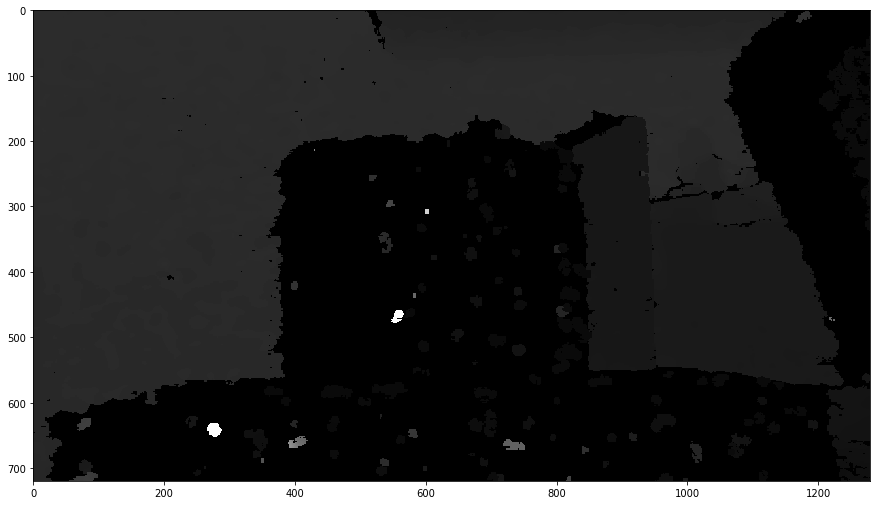

In [44]:

# Stop streaming
pipeline.stop()

fig = plt.figure(figsize=(15, 15))
plt.imshow(depth_image, cmap='gray')
plt.show()


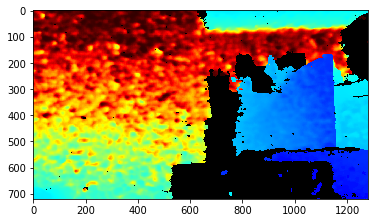

In [37]:
plt.imshow(colorized_depth)

In [49]:

# distance in m
#depth = depth * depth_scale
#dist,_,_,_ = cv2.mean(depth)

min_dist = depth_image.min()
print(min_dist)
max_dist = depth_image.max()
print(max_dist)


0
615
